# One VS Rest Multiclassification on MNIST

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import math
from math import *
import time
import random 
from numpy import linalg as LA
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
mnist = fetch_openml('mnist_784', version=1) #This is for fetching the MNIST data
mnist.keys()
U0, v0 = mnist["data"], mnist["target"]

C:\Users\RyanS\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
U = U0.astype(np.double) # changes the attribute values to float
v = v0.astype(np.uint8) # changes labels from string to integer
print(U.shape,"  ", v.shape)

(70000, 784)    (70000,)


In [4]:
#This creates a matrix of all the digits where each column is a corresponding digit.
#-1 if not that digit, 1 if it is that digit.
labelMatrix = np.full((len(v), 10), -1)

counter = 0
for i in v:
    
    labelMatrix[counter][i] = 1
    
    counter += 1

In [5]:
train_set_size,test_set_size = 5000,500  # you can adjust the train size here
N = train_set_size
N_test = test_set_size


#np.random.seed(0) # use this line if you want your train and test data remain the same accross experiments

#Generating shuffled split for train and test sets
shuffled_indices = np.random.permutation(len(v))
    
dic_train_set = {}
dic_train_set_indices = shuffled_indices[:train_set_size]
    
dic_test_set= {}
test_indices = shuffled_indices[-test_set_size:]

In [6]:
#Getting the labels for both after splitting test and train
vMatrixTrain = np.zeros((train_set_size, 10))
counter = 0
for i in dic_train_set_indices:
    vMatrixTrain[counter] = (labelMatrix[i])
    counter +=1
    
vMatrixTest = np.zeros((test_set_size, 10))
counter = 0
for i in test_indices:
    vMatrixTest[counter] = (labelMatrix[i])
    counter +=1
    
vMatrixTest2 = np.zeros((test_set_size))
counter = 0
for i in test_indices:
    vMatrixTest2[counter] = v[i]
    counter += 1

#IMPORTANT! vMatrixTest IS TRANSPOSE OF v_train USED IN GD/SGD CODE

In [7]:
#Get v_train for a specific digit
def getVTrain(digit):
    tempArr = np.zeros((train_set_size, 1))
    for i in range(train_set_size):
        tempArr[i] = vMatrixTrain[i][digit]
    return tempArr.T

In [8]:
#Getting the pixel data for each digit after splitting test and train
U_train = np.zeros((train_set_size, 784))
counter = 0
for i in dic_train_set_indices:
    U_train[counter] = (U.iloc[i])
    counter +=1
U_train = U_train.T

U_test = np.zeros((test_set_size, 784))
counter = 0
for i in test_indices:
    U_test[counter] = (U.iloc[i])
    counter +=1
U_test = U_test.T

# Stochastic Gradient Descent Code

In [9]:
#Function that finds the local gradient given a position x and randomized integer j. 
#For SGD
def localGradient(x, j):
    result = ((-U_train[:,[j]] * v_train[:,[j]]) / (1 + np.exp(-v_train[:,[j]] * np.dot(U_train.T[[j],:], x)))) / N
    return result

In [10]:
#Stochastic Gradient Descent function
def SGD(x0, step_size, kmax, epoch):
    xnow = x0
    xepoch = np.zeros((784, epoch+1))
    value = np.zeros(epoch+1)
    value[0] = logisticRegression(xnow)
    xepoch[:,[0]] = xnow
    counter = 1 #Counter for if statement in the for loop
    for k in range(kmax):
        xi = random.randint(0, N-1) #Randomizing a integer for SGD. Recall that N is total digits being tested
        xnow = xnow - step_size * localGradient(xnow, xi)
            
        #This is for collecting data that will be used in the graph
        if ((k+1) % math.ceil(kmax / epoch)) == 0:
            value[counter] = logisticRegression(xnow)
            xepoch[:,[counter]] = xnow
            counter +=1
    
    
    return xnow, value, xepoch

### Objective Function

In [11]:
def logisticRegression(x):
    return (sum(np.log(1 + np.exp(-v_train.T[[j],:] * np.dot(U_train.T[[j],:], x))) for j in range(N))) / N

# Running Everything

### Setting Parameters

# Graphing Descent of each digit

In [12]:
ss = 10 ** -7
x = np.zeros((784, 1))
kmax = 1000
ep = 10

xepochDict = {}

#These matrices will store the data for xnow & graphing data. Each column is the respective indexed digit
finalMatrix = np.zeros((784, 10))
finalGraphData = np.zeros((10, ep+1))


#Running the machine learning on all digits
for i in range(0, 10):
    v_train = getVTrain(i)
    xnow1 = np.zeros((784, 1))
    xnow1, graphData, xepochFinal =  SGD(x, ss, kmax, ep)
    
    xepochDict[i] = xepochFinal
    
    finalMatrix[:,[i]] = xnow1
    finalGraphData[[i],:] = graphData

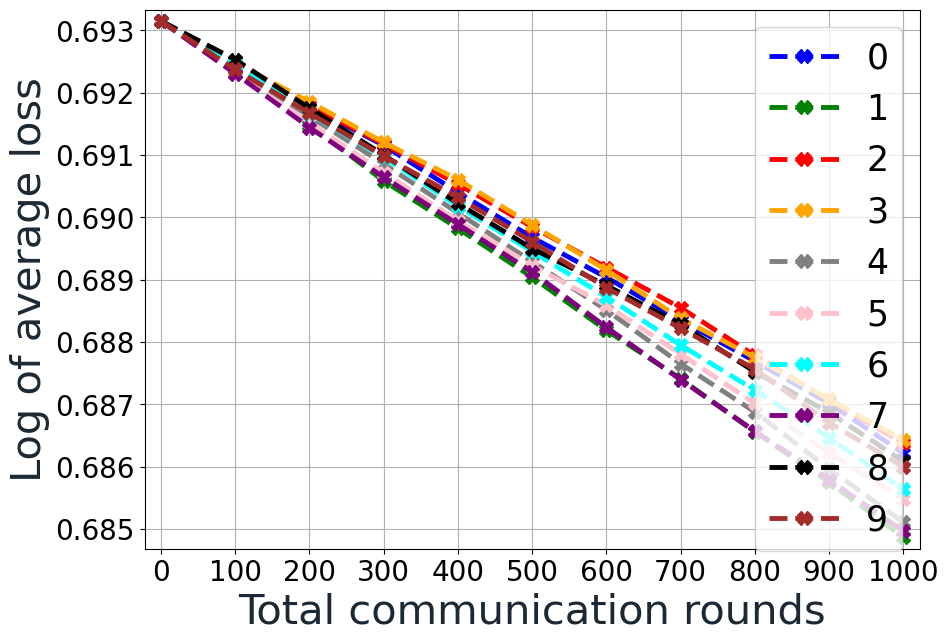

In [20]:
fig = plt.figure(figsize=(10,7))

#Plotting all 10 digit's SGD descents. Ideally they all converge.
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), finalGraphData[0], color='blue',
         marker='X',markersize=10,linestyle='dashed',label="0",linewidth=3.5)
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), finalGraphData[1], color='green',
         marker='X',markersize=10,linestyle='dashed',label="1",linewidth=3.5)
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), finalGraphData[2], color='red',
         marker='X',markersize=10,linestyle='dashed',label="2",linewidth=3.5)
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), finalGraphData[3], color='orange',
         marker='X',markersize=10,linestyle='dashed',label="3",linewidth=3.5)
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), finalGraphData[4], color='gray',
         marker='X',markersize=10,linestyle='dashed',label="4",linewidth=3.5)
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), finalGraphData[5], color='pink',
         marker='X',markersize=10,linestyle='dashed',label="5",linewidth=3.5)
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), finalGraphData[6], color='cyan',
         marker='X',markersize=10,linestyle='dashed',label="6",linewidth=3.5)
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), finalGraphData[7], color='purple',
         marker='X',markersize=10,linestyle='dashed',label="7",linewidth=3.5)
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), finalGraphData[8], color='black',
         marker='X',markersize=10,linestyle='dashed',label="8",linewidth=3.5)
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), finalGraphData[9], color='brown',
         marker='X',markersize=10,linestyle='dashed',label="9",linewidth=3.5)

#General formatting code
plt.legend(loc=1,fontsize=25)
plt.xlabel('Total communication rounds', color='#1C2833',fontsize=30)
plt.ylabel('Log of average loss', color='#1C2833',fontsize=30)
plt.xticks(range(0,kmax+1, math.ceil(kmax / ep)),fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.margins(0.022)


# Testing

In [14]:
#This function is used to generate the confusion matrix
def my_confu_mat(opt_sol):
    #Here rows are predic
    confu_mat = np.zeros((10, 10))
    
    currentBest = 0
    bestDigit = 0
    
    for i in range(N_test):
        for j in range(10):
            
            #This section is used to compare how positive the results are and keep the most positive
            if j == 0:
                currentBest = np.dot(U_test[:,i].T, opt_sol.T[j])
                bestDigit = 0
            elif currentBest < np.dot(U_test[:,i].T, opt_sol.T[j]):
                currentBest = np.dot(U_test[:,i].T, opt_sol.T[j])
                bestDigit = j
        
        confu_mat[bestDigit][int(vMatrixTest2[i])] += 1
    return confu_mat

In [15]:
#Pulling a confusion matrix from all xnows generated by SGD
final_confu_mat = my_confu_mat(finalMatrix)
print(final_confu_mat)

[[54.  0.  1.  3.  4. 24. 10.  6.  5.  0.]
 [ 0. 38.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0. 12. 31.  0. 12. 10. 27.  9. 15.  1.]
 [ 0.  1.  3. 34.  0. 11.  2.  2. 12.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  8.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  7.  0.]
 [ 0.  0.  0.  1. 54.  6.  0. 31. 11. 50.]]


In [16]:
#Function that determines accuracy by total correct / total sample size
def accuracy(mat):
    correct = 0;
    wrong = 0;
    for i in range(10):
        for j in range(10):
            if i != j:
                wrong += mat[i,j]
            else:
                correct += mat[i,j]
    return correct / (wrong + correct)

In [17]:
print("Accuracy is ", accuracy(final_confu_mat), "%")

Accuracy is  0.448 %


# xepoch Graphing

In [18]:
accuracyArr = np.zeros(ep + 1)

for i in range(ep + 1):
    tempMatrix = np.zeros((784, 10))
    for j in range(10):
        xnow = xepochDict[j][:,[i]]
        tempMatrix[:,[j]] = xnow
    
    
    f_confu_matrix = my_confu_mat(tempMatrix)
    accuracyArr[i] = accuracy(f_confu_matrix)
    
print(accuracyArr)

[0.108 0.29  0.396 0.392 0.402 0.432 0.43  0.418 0.426 0.472 0.448]


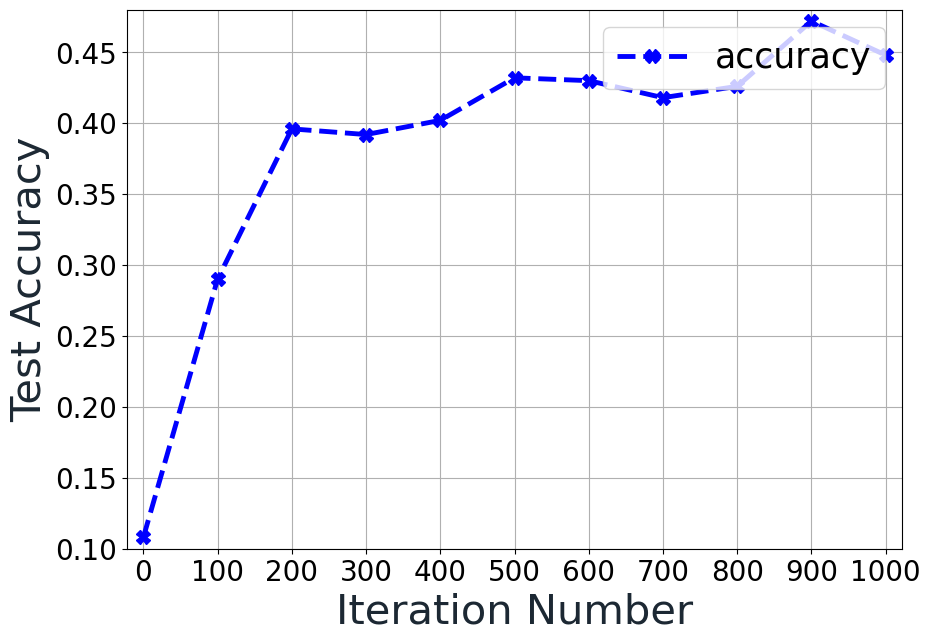

In [22]:
fig = plt.figure(figsize=(10,7))

#Plotting all 10 digit's SGD descents. Ideally they all converge.
plt.plot(range(0,kmax+1, math.ceil(kmax / ep)), accuracyArr, color='blue',
         marker='X',markersize=10,linestyle='dashed',label="accuracy",linewidth=3.5)

#General formatting code
plt.legend(loc=1,fontsize=25)
plt.xlabel('Iteration Number', color='#1C2833',fontsize=30)
plt.ylabel('Test Accuracy', color='#1C2833',fontsize=30)
plt.xticks(range(0,kmax+1, math.ceil(kmax / ep)),fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.margins(0.022)